In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import glob

In [37]:
#resize all images in folders and convert them from jpg to png
#empty list
image_list=[]
resized_images=[]

for filename in glob.glob('C:\\Users\\is-os\\corndataset\\blight\\*.jpg'):
    img=Image.open(filename)
    image_list.append(img)

    


In [38]:
for image in image_list:
    image=image.resize((256,256))
    resized_images.append(image)

In [39]:
for(i,new) in enumerate (resized_images):
    try:
        new.save('{}{}{}'.format('C:\\Users\is-os\\corndataset\\resized\\blight',i+1,'.png'))
    except Exception as e:
        print(f"Error while processing {image_filename}: {e}")

In [23]:
imgsize=256

In [49]:
#Import data into tensorflow dataset object
corndata = tf.keras.preprocessing.image_dataset_from_directory(
    "corndataset\\resized",
    seed=123,
    shuffle=True,
    image_size=(imgsize,imgsize),
    batch_size=42
)

Found 4185 files belonging to 4 classes.


In [50]:
names=corndata.class_names

In [42]:
names

['Common_Rust', 'Gray_Leaf_Spot', 'Healthy', 'blight']

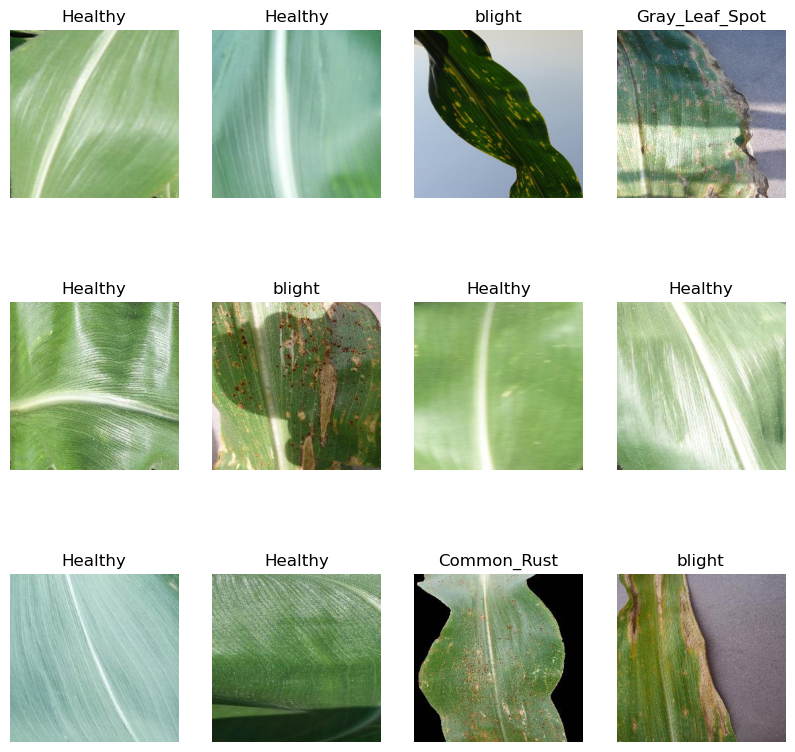

In [53]:
#ploting to see if they are ploted in good shape
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in corndata.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(names[labels_batch[i]])
        plt.axis("off")

In [55]:
len(corndata)

100

In [78]:
#split data into training test and val
train_size=int(0.8*len(corndata))
train_size
test_size=int(0.12*len(corndata))
val_size=int(0.08*len(corndata))


In [102]:
train_data=corndata.take(train_size)
len(train_data)

80

In [103]:
test_data=corndata.skip(train_size).take(test_size)
len(test_data)

12

In [104]:
val_data=corndata.skip(train_size+test_size).take(val_size)
len(val_data)

8

In [105]:
#parameter to resize a picture by deviding and to be between 0 and 1
rescaledata = tf.keras.Sequential([
   layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#train_data=train_data.map(rescaledata)

In [ ]:
#import numpy as np
#images1 = next(iter(train_data))
#print("Minimum pixel value:", np.min(images1))
#print("Maximum pixel value:", np.max(images1))

In [99]:
#parameter to augment the data to generate enough data for training 
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.4),
])


In [ ]:
#maping is for every augmented data must have exactly the same label
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [109]:
#using CNN and all the parameter above to train the model input 32 neuron and 4 for output since we have 4 classes
batchsize=42
channels=3
input_shape = (batchsize, imgsize, imgsize, channels)
n_classes = 4
model = models.Sequential([
    rescaledata,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [110]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (42, None, None, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (42, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (42, 127, 127, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (42, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (42, 62, 62, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (42, 60, 60, 64)         

In [111]:
#this parameter is for calculating loss and accuracy
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [112]:
#fit the model to train
history = model.fit(
    train_data,
    batch_size=batchsize,
    validation_data=val_data,
    verbose=1,
    epochs=50,
)

Epoch 1/50
80/80 [==============================] - 71s 636ms/step - loss: 1.1250 - accuracy: 0.4708 - val_loss: 0.9809 - val_accuracy: 0.6822
Epoch 2/50
80/80 [==============================] - 54s 668ms/step - loss: 0.7884 - accuracy: 0.6586 - val_loss: 0.6194 - val_accuracy: 0.7508
Epoch 3/50
80/80 [==============================] - 58s 721ms/step - loss: 0.5284 - accuracy: 0.7937 - val_loss: 0.5013 - val_accuracy: 0.8131
Epoch 4/50
80/80 [==============================] - 66s 816ms/step - loss: 0.4544 - accuracy: 0.8185 - val_loss: 0.3633 - val_accuracy: 0.8536
Epoch 5/50
80/80 [==============================] - 71s 875ms/step - loss: 0.4087 - accuracy: 0.8348 - val_loss: 0.3860 - val_accuracy: 0.8442
Epoch 6/50
80/80 [==============================] - 68s 842ms/step - loss: 0.3789 - accuracy: 0.8378 - val_loss: 0.3691 - val_accuracy: 0.8598
Epoch 7/50
80/80 [==============================] - 66s 818ms/step - loss: 0.3725 - accuracy: 0.8435 - val_loss: 0.3904 - val_accuracy: 0.8411

In [113]:
#evaluate the test data 
scores = model.evaluate(test_data)


12/12 [==============================] - 5s 113ms/step - loss: 0.1461 - accuracy: 0.9405


In [115]:
type(history.history['loss'])

list

In [119]:
history.history['loss'][10:]

[0.3227098882198334,
 0.2971320152282715,
 0.3231092691421509,
 0.27461206912994385,
 0.2774311304092407,
 0.29259729385375977,
 0.2842628061771393,
 0.27263614535331726,
 0.2774665057659149,
 0.2507058382034302,
 0.2397986650466919,
 0.2570011019706726,
 0.24255603551864624,
 0.2454424351453781,
 0.2442113608121872,
 0.2423626184463501,
 0.24717912077903748,
 0.22700351476669312,
 0.2235214114189148,
 0.31231576204299927,
 0.23497360944747925,
 0.22950321435928345,
 0.2172137349843979,
 0.20466965436935425,
 0.2163880616426468,
 0.2003469318151474,
 0.21866005659103394,
 0.18994389474391937,
 0.18725882470607758,
 0.2012973427772522,
 0.20166364312171936,
 0.2142663300037384,
 0.20070305466651917,
 0.20318062603473663,
 0.20438052713871002,
 0.1883934736251831,
 0.19363045692443848,
 0.21212336421012878,
 0.1974983811378479,
 0.17954562604427338]

In [121]:
accuracy=history.history['accuracy']

In [122]:
val_accuracy=history.history['val_accuracy']

In [123]:
loss = history.history['loss']
val_loss = history.history['val_loss']

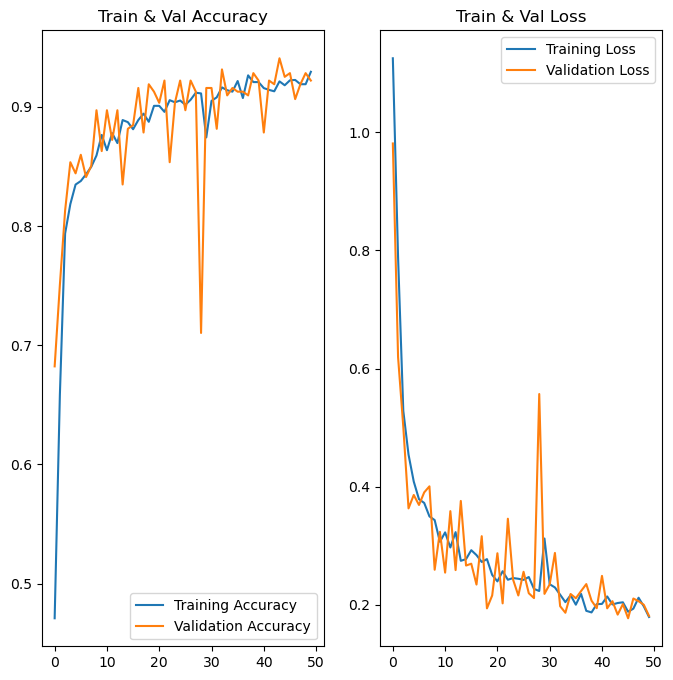

In [125]:
#simplyy ploting the result of our training into a plot for better visualisation
Epochs=50
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), accuracy, label='Training Accuracy')
plt.plot(range(Epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train & Val Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), loss, label='Training Loss')
plt.plot(range(Epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train & Val Loss')
plt.show()

In [129]:
#since we need to check the model performing well we need to predict multiple data so we need a function to go through data images
def prediction_function (model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr, 0)

    prediction = model.predict(img_arr)

    predicted_class = names[np.argmax(prediction[0])]
    legitness = round(100 * (np.max(prediction[0])), 2)
    return predicted_class, legitness

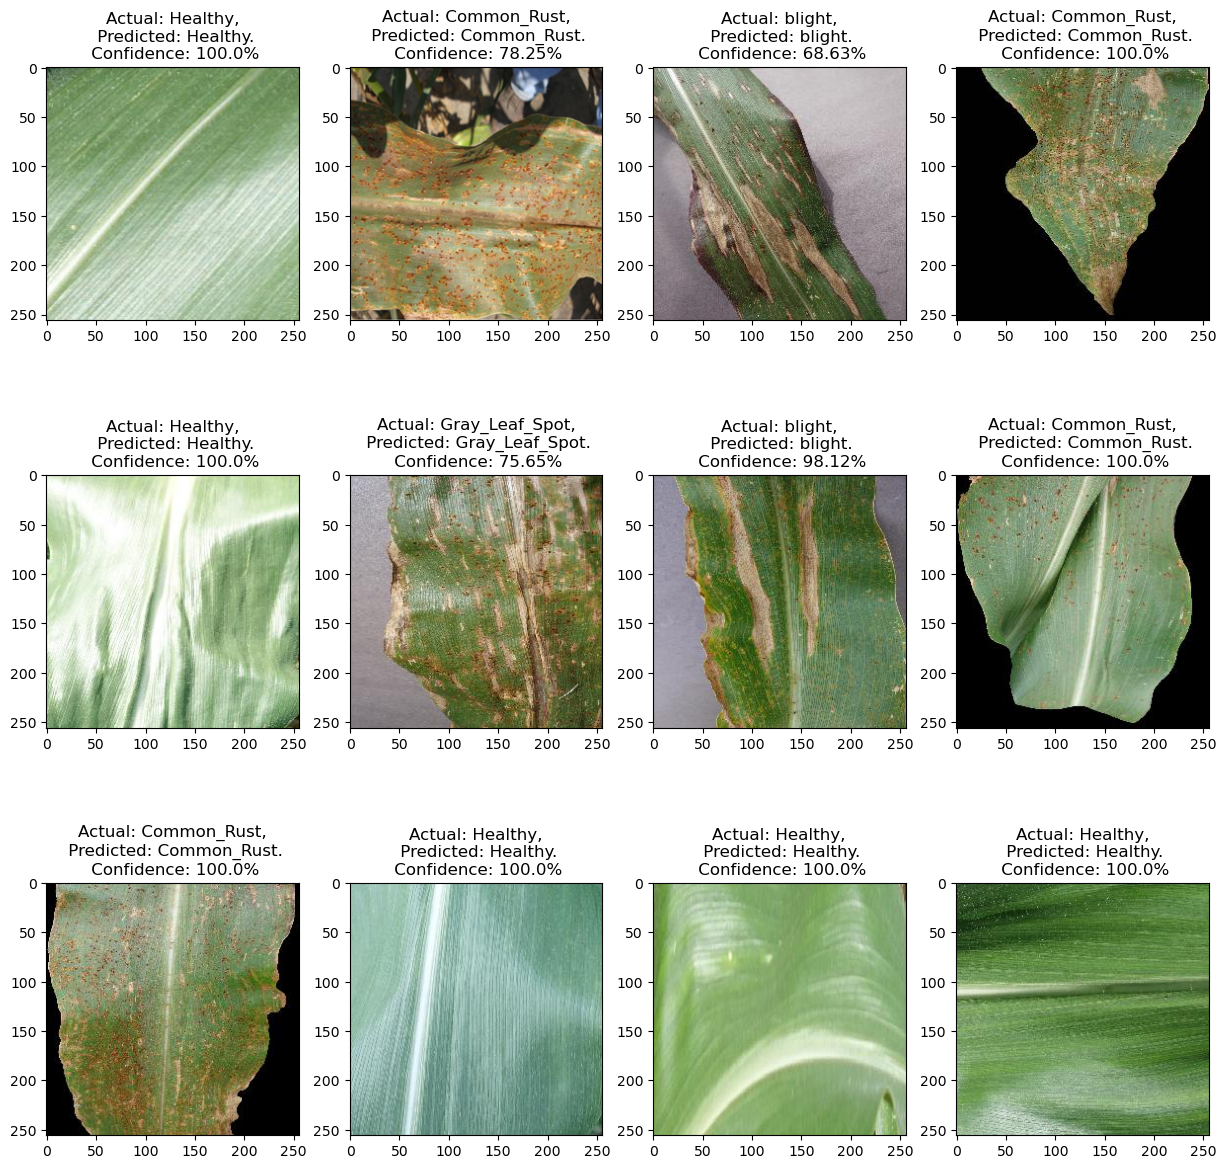

In [132]:
#plot the images using the function above
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(2):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, legitness = prediction_function(model, images[i].numpy())
        actual_class = names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {legitness}%")

In [135]:
#saving the model to use in the future 
from tensorflow.keras.models import load_model
model.save('cornclass.h5')